<a href="https://colab.research.google.com/github/therobinkay/gender_bias_2021/blob/main/Journal_Analysis_2_(GitHub).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import io
import pandas as pd
import os
import itertools
import numpy as np
import scipy.stats
import time

import matplotlib.pyplot as plt
import seaborn as sns

import statistics
import math

from tqdm.auto import tqdm

import networkx as nx
import random

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
!cd "drive/My Drive"

In [4]:
data = pd.read_csv("drive/My Drive/codes/data.csv")
# dp = pd.read_csv("drive/My Drive/codes/doipacs.csv")
cen = pd.read_csv('drive/My Drive/codes/cen.csv')

# cdata = pd.read_csv('drive/My Drive/codes/cdata.csv')

cb = pd.read_csv("drive/My Drive/codes/citationBara.csv")
cb['pair'] = "(" + cb["citing_doi"] + ", " + cb["cited_doi"] + ")"
cb['pair2'] = "(" + cb["cited_doi"] + ", " + cb["citing_doi"] + ")"

# 1. Year Diff. vs. Centrality Diff.

In [12]:
############## SELECT DESIRED PACS (HOMOPHILY ONLY) ###############

# homn = pd.read_csv("drive/My Drive/codes/hom0.csv")
# homn = pd.read_csv("drive/My Drive/codes/hom1.csv")
# homn = pd.read_csv("drive/My Drive/codes/hom2.csv")
# homn = pd.read_csv("drive/My Drive/codes/hom3.csv")
# homn = pd.read_csv("drive/My Drive/codes/hom4.csv")
# homn = pd.read_csv("drive/My Drive/codes/hom5.csv")
# homn = pd.read_csv("drive/My Drive/codes/hom6.csv")
# homn = pd.read_csv("drive/My Drive/codes/hom7.csv")
# homn = pd.read_csv("drive/My Drive/codes/hom8.csv")
homn = pd.read_csv("drive/My Drive/codes/hom9.csv")

print(len(homn))
homn.head()

103313


,paper1,gender1,year1,paper2,gender2,year2,qval,k
0,10.1103/PhysRevA.35.4035,male,1987,10.1103/PhysRevA.36.4163,male,1987,0.001441,False
1,10.1103/PhysRevA.36.4700,male,1987,10.1103/PhysRevA.38.1839,male,1988,0.003817,True
2,10.1103/PhysRevA.36.4700,male,1987,10.1103/PhysRevA.40.6260,male,1989,0.003817,True
3,10.1103/PhysRevA.38.1839,male,1988,10.1103/PhysRevA.40.6260,male,1989,0.000015,True
4,10.1103/PhysRevA.36.4700,male,1987,10.1103/PhysRevA.40.6931,male,1989,0.003817,True


In [13]:
dc = data[["doi", "year"]].drop_duplicates(subset = 'doi')
dc = dc.merge(cb, left_on = 'doi',
              right_on = 'citing_doi', how = 'inner').drop(
                  ['doi'], axis=1).rename({'year': 'citing_year'}, axis=1)

cols = ['citing_doi', 'citing_year', 'cited_doi']
dc = dc.reindex(columns=cols).sort_values('cited_doi')

In [14]:
hom_mf = homn[homn["gender1"] != homn["gender2"]].reset_index(drop=True)

test = hom_mf.merge(dc, left_on = 'paper1',
                    right_on = 'cited_doi', how = 'left').drop(
                        ["cited_doi", "citing_year"], axis=1).drop_duplicates(
                            subset=['paper1', 'citing_doi'])
test['count'] = test.groupby(['paper1'])['paper1'].transform('count')
test = test.drop(["citing_doi"], axis=1).rename({'count': 'count1'}, axis=1)

test = test.drop_duplicates(subset=['paper1', 'paper2']).drop(
    ['gender1', 'year1', 'paper2', 'gender2', 'year2', 'qval', 'k'], axis=1)
hom_mf = hom_mf.merge(test, on='paper1', how='inner')

test = hom_mf.merge(dc, left_on = 'paper2',
                    right_on = 'cited_doi', how = 'left').drop(
                        ["cited_doi", "citing_year"], axis=1).drop_duplicates(
                            subset=['paper2', 'citing_doi'])
test['count'] = test.groupby(['paper2'])['paper2'].transform('count')
test = test.drop(["citing_doi"], axis=1).rename(
    {'count': 'count2'}, axis=1).drop_duplicates(
        subset=['paper1', 'paper2']).drop(
            ['gender1', 'year1', 'paper1', 'gender2', 'count1',
             'year2', 'qval', 'k'], axis=1)
hom_mf = hom_mf.merge(test, on='paper2', how='inner')

del test

print(len(hom_mf))
print(hom_mf['paper1'].nunique())
hom_mf.head()

18760
2599


,paper1,gender1,year1,paper2,gender2,year2,qval,k,count1,count2
0,10.1103/PhysRevA.42.3587,male,1990,10.1103/PhysRevD.56.3296,female,1997,0.009174,False,14,3
1,10.1103/PhysRevD.48.5655,male,1993,10.1103/PhysRevD.56.3296,female,1997,0.009174,False,8,3
2,10.1103/PhysRevD.50.1161,male,1994,10.1103/PhysRevD.56.3296,female,1997,0.009174,False,1,3
3,10.1103/PhysRevD.50.3847,male,1994,10.1103/PhysRevD.56.3296,female,1997,0.009174,False,4,3
4,10.1103/PhysRevD.52.6901,male,1995,10.1103/PhysRevD.56.3296,female,1997,0.009174,False,4,3


In [8]:
listd = []
listy = []

for c in range(len(hom_mf)):
  if hom_mf['gender1'][c] == 'male':
    listd.append(hom_mf['count1'][c] - hom_mf['count2'][c])
    listy.append(hom_mf['year1'][c] - hom_mf['year2'][c])
  else:
    listd.append(hom_mf['count2'][c] - hom_mf['count1'][c])
    listy.append(hom_mf['year2'][c] - hom_mf['year1'][c])

hom_mf['countd'] = listd
hom_mf['yeard'] = listy

print(len(hom_mf))
hom_mf.head()

18760


,paper1,gender1,year1,paper2,gender2,year2,qval,k,count1,count2,countd,yeard
0,10.1103/PhysRevA.42.3587,male,1990,10.1103/PhysRevD.56.3296,female,1997,0.009174,False,14,3,11,-7
1,10.1103/PhysRevD.48.5655,male,1993,10.1103/PhysRevD.56.3296,female,1997,0.009174,False,8,3,5,-4
2,10.1103/PhysRevD.50.1161,male,1994,10.1103/PhysRevD.56.3296,female,1997,0.009174,False,1,3,-2,-3
3,10.1103/PhysRevD.50.3847,male,1994,10.1103/PhysRevD.56.3296,female,1997,0.009174,False,4,3,1,-3
4,10.1103/PhysRevD.52.6901,male,1995,10.1103/PhysRevD.56.3296,female,1997,0.009174,False,4,3,1,-2


In [ ]:
# use p-values from the paper
p = 0.006

homp = hom_mf[hom_mf['qval'] < p].sort_values('countd').reset_index(drop=True)

(-54.0, 60.0)

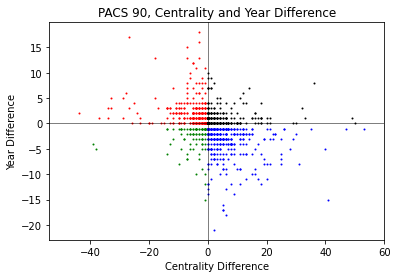

In [ ]:
# build scatterplots

# zeros are included for the graphic reasons - removed for analysis

block13 = homp[homp['yeard'] >= 0]
block24 = homp[homp['yeard'] < 0]

block1 = block13[block13['countd'] >= 0]
block3 = block13[block13['countd'] < 0]
block4 = block24[block24['countd'] >= 0]
block2 = block24[block24['countd'] < 0]

plt.title("PACS 90, Centrality and Year Difference")
plt.scatter(block1.countd, block1.yeard, s=1, c='black')
plt.scatter(block2.countd, block2.yeard, s=1, c='g')
plt.scatter(block3.countd, block3.yeard, s=1, c='r')
plt.scatter(block4.countd, block4.yeard, s=1, c='b')
plt.axhline(y=0, linewidth=0.5, c='k')
plt.axvline(x=0, linewidth=0.5, c='k')
plt.xlabel("Centrality Difference")
plt.ylabel("Year Difference")
plt.xlim(xmax=60)
# plt.xlim(xmin=-100)

In [ ]:
# remove zeros

block13 = homp[homp['yeard'] > 0]
block1 = block13[block13['countd'] > 0]
block4 = block24[block24['countd'] > 0]

In [ ]:
comp13 = []

for i in range(1,11):
  b1 = block1[block1['yeard'] == i]
  b3 = block3[block3['yeard'] == i]
  if len(b1) < 2 or len(b3) < 2:
    print('NA')
    comp13.append('NA')
  else:
    xd = b1['countd'].mean() - b3['countd'].mean()
    var = math.sqrt(statistics.stdev(b1['countd'])**2 +
                    statistics.stdev(b3['countd'])**2)

    print(xd/var)
    comp13.append(xd/var)

1.173904865318404
1.3022159413231136
1.1330136358908969
1.7247474636694409
1.568292470721645
NA
1.375597058468528
0.9274746114093078
NA
NA


In [ ]:
comp42 = []

for i in range(1,11):
  b4 = block4[block4['yeard'] == -i]
  b2 = block2[block2['yeard'] == -i]
  if len(b4) < 2 or len(b2) < 2:
    print('NA')
    comp13.append('NA')
  else:
    xd = b4['countd'].mean() - b2['countd'].mean()
    var = math.sqrt(statistics.stdev(b4['countd'])**2 +
                    statistics.stdev(b2['countd'])**2)

    print(xd/var)
    comp42.append(xd/var)

1.1804039165593339
0.6632428273111366
1.5520982515720987
0.846809132799925
1.0160064584282458
1.8980224257908334
0.6300702520805452
NA
NA
1.9654188579355578


# 1b. Centrality Difference Trend by Year

In [9]:
############## SELECT DESIRED PACS (HOMOPHILY ONLY) ###############

# homn = pd.read_csv("drive/My Drive/codes/hom0.csv")
# homn = pd.read_csv("drive/My Drive/codes/hom1.csv")
# homn = pd.read_csv("drive/My Drive/codes/hom2.csv")
# homn = pd.read_csv("drive/My Drive/codes/hom3.csv")
# homn = pd.read_csv("drive/My Drive/codes/hom4.csv")
# homn = pd.read_csv("drive/My Drive/codes/hom5.csv")
# homn = pd.read_csv("drive/My Drive/codes/hom6.csv")
# homn = pd.read_csv("drive/My Drive/codes/hom7.csv")
# homn = pd.read_csv("drive/My Drive/codes/hom8.csv")
homn = pd.read_csv("drive/My Drive/codes/hom9.csv")

print(len(homn))
homn.head()

103313


,paper1,gender1,year1,paper2,gender2,year2,qval,k
0,10.1103/PhysRevA.35.4035,male,1987,10.1103/PhysRevA.36.4163,male,1987,0.001441,False
1,10.1103/PhysRevA.36.4700,male,1987,10.1103/PhysRevA.38.1839,male,1988,0.003817,True
2,10.1103/PhysRevA.36.4700,male,1987,10.1103/PhysRevA.40.6260,male,1989,0.003817,True
3,10.1103/PhysRevA.38.1839,male,1988,10.1103/PhysRevA.40.6260,male,1989,0.000015,True
4,10.1103/PhysRevA.36.4700,male,1987,10.1103/PhysRevA.40.6931,male,1989,0.003817,True


In [15]:
dc = data[["doi", "year"]].drop_duplicates(subset = 'doi')
dc = dc.merge(cb, left_on = 'doi',
              right_on = 'citing_doi', how = 'inner').drop(
                  ['doi'], axis=1).rename({'year': 'citing_year'}, axis=1)

cols = ['citing_doi', 'citing_year', 'cited_doi']
dc = dc.reindex(columns=cols).sort_values('cited_doi')

hom_mf = homn[homn["gender1"] != homn["gender2"]].reset_index(drop=True)

test = hom_mf.merge(dc, left_on = 'paper1',
                    right_on = 'cited_doi', how = 'left').drop(
                        ["cited_doi", "citing_year"], axis=1).drop_duplicates(
                            subset=['paper1', 'citing_doi'])
test['count'] = test.groupby(['paper1'])['paper1'].transform('count')
test = test.drop(["citing_doi"], axis=1).rename({'count': 'count1'}, axis=1)

test = test.drop_duplicates(subset=['paper1', 'paper2']).drop(
    ['gender1', 'year1', 'paper2', 'gender2', 'year2', 'qval', 'k'], axis=1)
hom_mf = hom_mf.merge(test, on='paper1', how='inner')

test = hom_mf.merge(dc, left_on = 'paper2',
                    right_on = 'cited_doi', how = 'left').drop(
                        ["cited_doi", "citing_year"], axis=1).drop_duplicates(
                            subset=['paper2', 'citing_doi'])
test['count'] = test.groupby(['paper2'])['paper2'].transform('count')
test = test.drop(["citing_doi"], axis=1).rename(
    {'count': 'count2'}, axis=1).drop_duplicates(
        subset=['paper1', 'paper2']).drop(
            ['gender1', 'year1', 'paper1', 'gender2', 'count1',
             'year2', 'qval', 'k'], axis=1)
hom_mf = hom_mf.merge(test, on='paper2', how='inner')

del test

listd = []
listy = []

for c in range(len(hom_mf)):
  if hom_mf['gender1'][c] == 'male':
    listd.append(hom_mf['count1'][c] - hom_mf['count2'][c])
    listy.append(hom_mf['year1'][c] - hom_mf['year2'][c])
  else:
    listd.append(hom_mf['count2'][c] - hom_mf['count1'][c])
    listy.append(hom_mf['year2'][c] - hom_mf['year1'][c])

hom_mf['countd'] = listd
hom_mf['yeard'] = listy

print(len(hom_mf))
hom_mf.head()

18760


,paper1,gender1,year1,paper2,gender2,year2,qval,k,count1,count2,countd,yeard
0,10.1103/PhysRevA.42.3587,male,1990,10.1103/PhysRevD.56.3296,female,1997,0.009174,False,14,3,11,-7
1,10.1103/PhysRevD.48.5655,male,1993,10.1103/PhysRevD.56.3296,female,1997,0.009174,False,8,3,5,-4
2,10.1103/PhysRevD.50.1161,male,1994,10.1103/PhysRevD.56.3296,female,1997,0.009174,False,1,3,-2,-3
3,10.1103/PhysRevD.50.3847,male,1994,10.1103/PhysRevD.56.3296,female,1997,0.009174,False,4,3,1,-3
4,10.1103/PhysRevD.52.6901,male,1995,10.1103/PhysRevD.56.3296,female,1997,0.009174,False,4,3,1,-2


In [55]:
plot_hom = hom_mf.groupby(['year2','countd']).size().reset_index(name='count')
# plot_hom = plot_hom.astype(float)
plot_hom

,year2,countd,count
0,1982,-6,1
1,1982,7,2
2,1983,5,2
3,1984,19,1
4,1986,-2,1
...,...,...,...
1608,2009,80,1
1609,2009,82,3
1610,2009,83,1
1611,2009,84,1


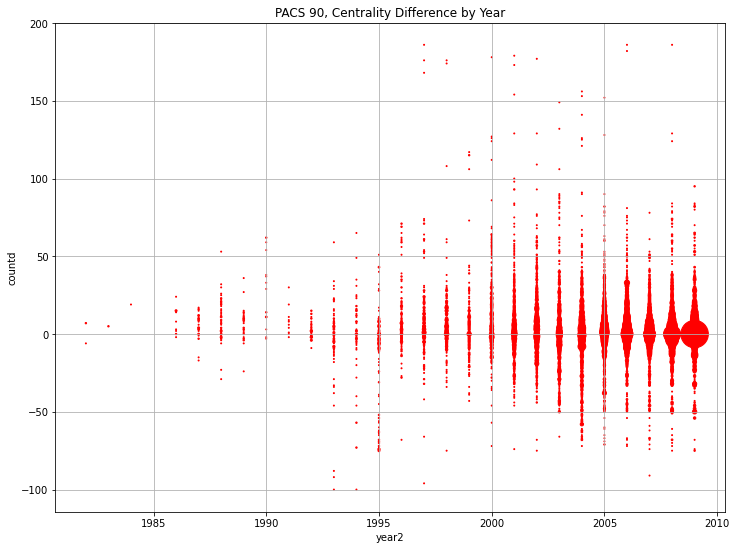

In [69]:
# ax1 = plot_hom.plot.scatter(x='year2',y='countd', c='red')

# plt.title("PACS 90, Centrality Difference by Year")
# plt.scatter(plot_hom.year2, plot_hom.countd, s=plot_hom.count, c='r')
# plt.xlabel("Year")
# plt.ylabel("Centrality Difference")
# plt.xlim(xmax=60)
# plt.xlim(xmin=-100)

ax1 = plot_hom.plot.scatter(x="year2", y="countd", c='red', s="count",
                            figsize=(12,9), grid=True, xlabel="Year", 
                            ylabel="Centrality Difference",
                            title="PACS 90, Centrality Difference by Year")

# 2a. Gender citing gender (setup)

In [ ]:
def cit_count(g):

    # count x2-> y2 pairs
    df1 = g.drop_duplicates(subset=['cit1', 'paper1', 'pair'])
    c1 = (df1['cgen1'] + '_' + df1['gender1']).value_counts()

    # count x2-> y2 pairs
    df2 = g.drop_duplicates(subset=['cit2', 'paper2', 'pair'])
    c2 = (df2['cgen2'] + '_' + df2['gender2']).value_counts()

    # add results
    return c1.add(c2, fill_value=0)

In [ ]:
############## SELECT DESIRED PACS (HOMOPHILY ONLY) ###############

# homn = pd.read_csv("drive/My Drive/codes/hom0.csv")
# homn = pd.read_csv("drive/My Drive/codes/hom1.csv")
# homn = pd.read_csv("drive/My Drive/codes/hom2.csv")
# homn = pd.read_csv("drive/My Drive/codes/hom3.csv")
# homn = pd.read_csv("drive/My Drive/codes/hom4.csv")
# homn = pd.read_csv("drive/My Drive/codes/hom5.csv")
# homn = pd.read_csv("drive/My Drive/codes/hom6.csv")
# homn = pd.read_csv("drive/My Drive/codes/hom7.csv")
# homn = pd.read_csv("drive/My Drive/codes/hom8.csv")
homn = pd.read_csv("drive/My Drive/codes/hom9.csv")

time: 892 ms (started: 2021-03-30 06:44:46 +00:00)


In [ ]:
hom = homn.drop(['year1', 'year2', 'k'], axis=1)

cen = cen.rename({'citing_doi': 'cit', 'citing_gender': 'cgender',
                          'cited_doi': 'paper', 'cited_gender': 'pgender'},
                          axis=1)

hom = hom[hom['gender1'] != hom['gender2']]

time: 62.9 ms (started: 2021-03-30 06:44:48 +00:00)


In [ ]:
# DataFrame: cit1 cites paper1, cit2 cites paper2
# where paper1 and paper 2 are similar pairs

test = pd.merge(cen, hom, left_on='paper', right_on='paper1',
                how='inner').drop(['paper', 'pgender'], axis=1).rename(
                    {'cit': 'cit1', 'cgender': 'cgen1'}, axis=1)

test = test.merge(cen, left_on='paper2',
                  right_on='paper', how='inner').drop(
                      ['paper', 'pgender'], axis=1).rename(
                          {'cit': 'cit2', 'cgender': 'cgen2'}, axis=1)
test = test[['cit1', 'cgen1', 'cit2', 'cgen2', 'paper1', 'gender1', 'paper2',
             'gender2', 'qval']]

print(len(test))
test.head()

731817


,cit1,cgen1,cit2,cgen2,paper1,gender1,paper2,gender2,qval
0,10.1103/PhysRevD.79.103502,male,10.1103/PhysRevD.77.063511,female,10.1103/PhysRevD.70.103518,male,10.1103/PhysRevD.77.063510,female,0.032609
1,10.1103/PhysRevD.79.103502,male,10.1103/PhysRevD.77.063510,female,10.1103/PhysRevD.70.103518,male,10.1103/PhysRevD.77.063510,female,0.032609
2,10.1103/RevModPhys.78.537,male,10.1103/PhysRevD.77.063511,female,10.1103/PhysRevD.70.103518,male,10.1103/PhysRevD.77.063510,female,0.032609
3,10.1103/RevModPhys.78.537,male,10.1103/PhysRevD.77.063510,female,10.1103/PhysRevD.70.103518,male,10.1103/PhysRevD.77.063510,female,0.032609
4,10.1103/PhysRevD.77.023514,male,10.1103/PhysRevD.77.063511,female,10.1103/PhysRevD.70.103518,male,10.1103/PhysRevD.77.063510,female,0.032609


time: 607 ms (started: 2021-03-30 06:44:50 +00:00)


In [ ]:
test['pair'] = test.groupby(['paper1', 'paper2']).ngroup()
test = test.sort_values(['pair','cit1','cit2'])

print(test.pair.nunique())
test.head()

13632


,cit1,cgen1,cit2,cgen2,paper1,gender1,paper2,gender2,qval,pair
48018,10.1103/PhysRevA.46.3413,male,10.1103/PhysRevD.65.063004,female,10.1103/PhysRevA.42.3587,male,10.1103/PhysRevD.56.3296,female,0.009174,0
48019,10.1103/PhysRevA.46.3413,male,10.1103/PhysRevD.77.043529,male,10.1103/PhysRevA.42.3587,male,10.1103/PhysRevD.56.3296,female,0.009174,0
48020,10.1103/PhysRevA.46.3413,male,10.1103/PhysRevLett.82.4835,female,10.1103/PhysRevA.42.3587,male,10.1103/PhysRevD.56.3296,female,0.009174,0
48024,10.1103/PhysRevD.48.5655,male,10.1103/PhysRevD.65.063004,female,10.1103/PhysRevA.42.3587,male,10.1103/PhysRevD.56.3296,female,0.009174,0
48025,10.1103/PhysRevD.48.5655,male,10.1103/PhysRevD.77.043529,male,10.1103/PhysRevA.42.3587,male,10.1103/PhysRevD.56.3296,female,0.009174,0


time: 600 ms (started: 2021-03-30 06:44:53 +00:00)


In [ ]:
genco = test.groupby('pair').apply(cit_count).unstack().fillna(0).astype(int)

time: 1min 26s (started: 2021-03-30 06:44:56 +00:00)


In [ ]:
# genco.to_csv(r'drive/My Drive/codes/genco00.csv',index=False)
# genco.to_csv(r'drive/My Drive/codes/genco10.csv',index=False)
# genco.to_csv(r'drive/My Drive/codes/genco20.csv',index=False)
# genco.to_csv(r'drive/My Drive/codes/genco30.csv',index=False)
# genco.to_csv(r'drive/My Drive/codes/genco40.csv',index=False)
# genco.to_csv(r'drive/My Drive/codes/genco50.csv',index=False)
# genco.to_csv(r'drive/My Drive/codes/genco60.csv',index=False)
# genco.to_csv(r'drive/My Drive/codes/genco70.csv',index=False)
# genco.to_csv(r'drive/My Drive/codes/genco80.csv',index=False)
genco.to_csv(r'drive/My Drive/codes/genco90.csv',index=False)

time: 32.7 ms (started: 2021-03-30 06:46:22 +00:00)


# 2b. Gender citing gender

In [ ]:
############## SELECT DESIRED PACS (HOMOPHILY ONLY) ###############

# genco = pd.read_csv("drive/My Drive/codes/genco00.csv")
# genco = pd.read_csv("drive/My Drive/codes/genco10.csv")
# genco = pd.read_csv("drive/My Drive/codes/genco20.csv")
# genco = pd.read_csv("drive/My Drive/codes/genco30.csv")
# genco = pd.read_csv("drive/My Drive/codes/genco40.csv")
# genco = pd.read_csv("drive/My Drive/codes/genco50.csv")
# genco = pd.read_csv("drive/My Drive/codes/genco60.csv")
# genco = pd.read_csv("drive/My Drive/codes/genco70.csv")
# genco = pd.read_csv("drive/My Drive/codes/genco80.csv")
genco = pd.read_csv("drive/My Drive/codes/genco90.csv")

time: 16.4 ms (started: 2021-03-30 07:21:34 +00:00)


In [ ]:
genco['M'] = genco['male_male'] / (
    genco['male_male'] + genco['male_female'])
genco['F'] = genco['female_female'] / (
    genco['female_male'] + genco['female_female'])
genco = genco.fillna(0)

time: 9.02 ms (started: 2021-03-30 07:13:33 +00:00)


In [ ]:
print(statistics.mean(genco['M']))
print(scipy.stats.sem(genco['M'], axis=None))
print(statistics.mean(genco['F']))
print(scipy.stats.sem(genco['F'], axis=None))

0.5764143237420447
0.002423995004531813
0.5052111363062443
0.0037250616225795383
time: 42.8 ms (started: 2021-03-30 07:13:33 +00:00)


# 2c. Overall GCG Statistics

In [ ]:
genco0 = pd.read_csv("drive/My Drive/codes/genco00.csv")
genco1 = pd.read_csv("drive/My Drive/codes/genco10.csv")
genco2 = pd.read_csv("drive/My Drive/codes/genco20.csv")
genco3 = pd.read_csv("drive/My Drive/codes/genco30.csv")
genco4 = pd.read_csv("drive/My Drive/codes/genco40.csv")
genco5 = pd.read_csv("drive/My Drive/codes/genco50.csv")
genco6 = pd.read_csv("drive/My Drive/codes/genco60.csv")
genco7 = pd.read_csv("drive/My Drive/codes/genco70.csv")
genco8 = pd.read_csv("drive/My Drive/codes/genco80.csv")
genco9 = pd.read_csv("drive/My Drive/codes/genco90.csv")

time: 193 ms (started: 2021-03-30 07:02:06 +00:00)


In [ ]:
genco_n = pd.concat([genco0, genco1, genco2, genco3, genco4, genco5,
                     genco6, genco7, genco8, genco9])
genco_n.head()

,female_female,female_male,male_female,male_male
0,1,0,1,5
1,0,0,3,22
2,1,0,0,3
3,1,0,0,24
4,1,0,0,4


time: 29.7 ms (started: 2021-03-30 07:02:35 +00:00)


In [ ]:
genco_n['M'] = genco_n['male_male'] / (
    genco_n['male_male'] + genco_n['male_female'])
genco_n['F'] = genco_n['female_female'] / (
    genco_n['female_male'] + genco_n['female_female'])
genco_n = genco_n.fillna(0)

time: 47.1 ms (started: 2021-03-30 07:03:58 +00:00)


In [ ]:
print(statistics.mean(genco_n['M']))
print(statistics.stdev(genco_n['M']))
print(scipy.stats.sem(genco_n['M'], axis=None))
print(statistics.mean(genco_n['F']))
print(statistics.stdev(genco_n['F']))
print(scipy.stats.sem(genco_n['F'], axis=None))

0.579407368379222
0.29992456395122274
0.00038316824833655924
0.5473017630052013
0.4437672136252252
0.0005669342439775178
time: 4.58 s (started: 2021-03-30 07:03:59 +00:00)
